In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# 人群感染数据
data = np.array([184, 173, 165, 142, 128, 116, 101, 86, 63, 56, 46, 35, 22, 15, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0])[::-1]
# 定义初始情况，易感染人数1000万人，感染人3，恢复人0
S0, I0, R0 = 9000, 3, 0
# 定义16天
t = np.linspace(0, 24, 25)
def SIR(sir, t, beta, gamma):
    S, I, R = sir
    dsdt = - beta * S * I
    didt = beta * S * I - gamma * I
    drdt = gamma * I
    return [dsdt, didt, drdt]

def f(beta, gamma):
    # 求解时序变化
    corr = []
    for a, b in zip(beta, gamma):
        result = odeint(SIR, [S0, I0, R0], t, args=(a, b))
        St, It, Rt = result[:, 0], result[:, 1], result[:, 2]
        corr.append(np.mean((It-data)**2))
    return np.array(corr)
# 定义粒子个数
N = 20
# 定义惯性因子
w = 0.1
# 定义C1，C2
c1, c2 = 2, 2
# 初始化位置
x = np.random.uniform(0, 1, [N, 2])
x[:, 0] *= 0.04
x[:, 1] *= 0.25
# 初始化速度
v = np.random.uniform(0, 1, [N, 2])
v[:, 0] *= 0.04 * 0.03
v[:, 1] *= 0.25 * 0.03
# 个体最佳位置
p_best = np.copy(x)

fitness = f(x[:, 0], x[:, 1])
fitness = np.expand_dims(fitness, 1)
# 群体最佳位置
g_best = p_best[np.argmin(fitness)]
N_step = 1000
store = np.zeros([N, N_step, 2])
for step in range(N_step):
    # 计算速度v
    store[:, step, :] = x
    r1, r2 = np.random.random([N, 1]), np.random.random([N, 1])
    v = w * v + (1-w)*(c1 * r1 * (p_best - x) + c2 * r2 * (g_best - x))
    # 更新位置
    x = x + v
    x = np.clip(x, 0, 0.5)
    # 计算适应度
    fitness_new = f(x[:, 0], x[:, 1])
    fitness_new = np.expand_dims(fitness_new, 1)
    fit = np.concatenate([fitness, fitness_new], 1)
    fitness = fitness_new
    # 计算个体最优解
    p_best_for_sel = np.concatenate([
        np.expand_dims(x, 1),
        np.expand_dims(p_best, 1)], 1)
    p_best = p_best_for_sel[[i for i in range(N)], np.argmin(fit, 1), :]
    fit_p = f(p_best[:, 0], p_best[:, 1])
    # 计算全局最优解
    g_best = x[np.argmin(fitness[:, 0])]
#     print(g_best)
a, b = g_best
dt = np.linspace(0, 30, 1000)
result = odeint(SIR, [S0, I0, R0], dt, args=(a, b))
St, It, Rt = result[:, 0], result[:, 1], result[:, 2]

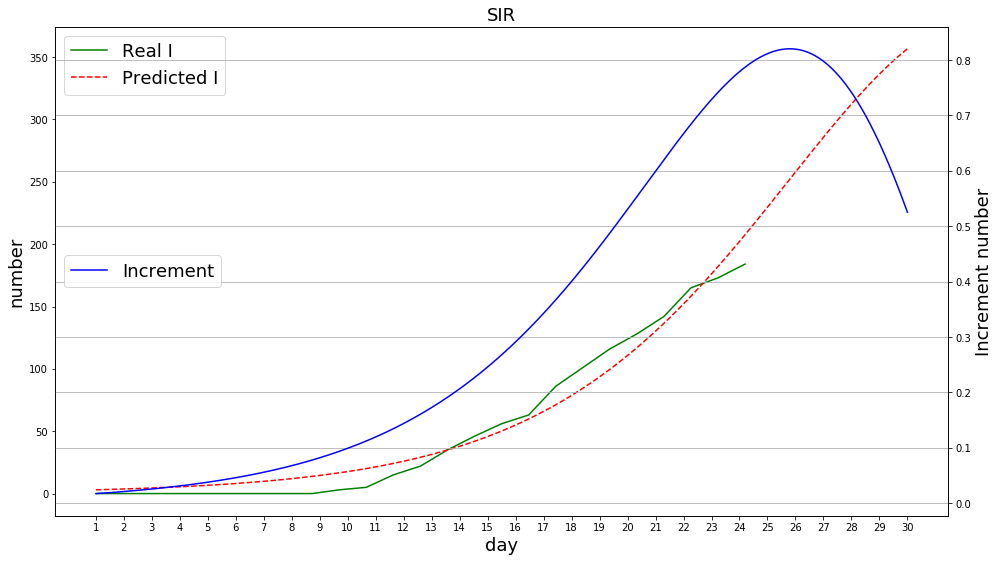

In [2]:
# 绘图
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(t, data, c="g", label="Real I")
ax1.plot(dt, It, c="r", linestyle="--", label="Predicted I")

ax2 = ax1.twinx()
ax2.plot(dt[1:], It[1:]-It[:-1], c="b", label="Increment")
ax2.legend(fontsize=18,loc=6)
ax2.set_ylabel("Increment number", fontsize=18)
ax1.set_title("SIR", fontsize=18)
ax1.set_xlabel("day", fontsize=18)

ax1.set_ylabel("number", fontsize=18)
ax1.legend(fontsize=18)
plt.grid(True)
time = np.linspace(0, 30, 30)
name = ( h for h in range(1, 31))
plt.xticks(time, name);